Building 2 ensembles and comparing their performances on the MNIST dataset:
1. Hard & Soft Voting Classifier
2. Stacking Ensemble

# Data Fetching

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
%time X, y = fetch_openml(name='mnist_784', version=1, return_X_y=True)

# X.to_csv('Sets/X.csv', index=False)
# y.to_csv('Sets/y.csv', index=False)

CPU times: total: 1min
Wall time: 1min 10s


In [3]:
# import pandas as pd

# X = pd.read_csv('Sets/X.csv')
# y = pd.read_csv('Sets/y.csv')

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

def split_data(X, y, train_size=50000, val_size=10000):
    '''
    Split `X` and `y` into train, val and test sets with sizes:
    train_size = 50,000
    val_size = 10,000
    test_size=70,000 - ( train_size+val_size ) = 10,000
    
    returns in order X_train, X_val, X_test, y_train, y_val, y_test
    as np.ndarray objects
    '''
    test_size = 70000 - (train_size + val_size)
    
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_size, random_state=42)
    
    X_train_arr = np.asarray(X_train)
    X_val_arr = np.asarray(X_val)
    X_test_arr = np.asarray(X_test)
    y_train_arr = np.asarray(y_train)
    y_val_arr = np.asarray(y_val)
    y_test_arr = np.asarray(y_test)
    
    return X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr

In [6]:
%%time
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

for SET in [X_train, X_val, X_test, y_train, y_val, y_test]:
    print(f'{SET.shape}, {SET.dtype}')

(50000, 784), float64
(10000, 784), float64
(10000, 784), float64
(50000,), object
(10000,), object
(10000,), object
CPU times: total: 1.34 s
Wall time: 1.34 s


## Saving Test sets for later

In [7]:
filesave_path = 'Sets/test_sets_MNIST'
# np.savez(filesave_path, X=X_test, y=y_test)

# Training - Base models

Training a variety of base models: 
1. Logistic Regression
2. SVM Classifier
3. Decision Tree
4. Extra trees

1. Logistic Regression 

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty='l1', solver='saga', C=0.8, tol=0.1, multi_class='multinomial', verbose=3, random_state=42)
log_reg.fit(X_train, y_train)

2. SVM Classifier

In [ ]:
%%time
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(dual=False, C=10, tol=0.1, max_iter=100, verbose=10, random_state=42)
svm_clf.fit(X_train, y_train)

3. Decision Tree

In [ ]:
%%time 
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(splitter='random', max_depth=8, max_features=0.5, random_state=42)
tree_clf.fit(X_train, y_train)

4. Extra trees

In [ ]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(max_depth=4, bootstrap=True, max_samples=0.33, verbose=5, n_jobs=-1, random_state=42)
et_clf.fit(X_train, y_train)

## Saving Base models

pickle.dump

In [ ]:
import pickle

filename_log_reg = 'Sets/log_reg_model.pkl'
filename_svm = 'Sets/svm_model.pkl'
filename_dec_tree = 'Sets/dec_tree_model.pkl'
filename_xtraa_trees = 'Sets/xtraa_trees_model.pkl'

for model, filename in zip([log_reg, svm_clf, tree_clf, et_clf], 
                           [filename_log_reg, filename_svm, filename_dec_tree, filename_xtraa_trees]):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

pickle.load

In [8]:
import pickle

filename_log_reg = 'Sets/log_reg_model.pkl'
filename_svm = 'Sets/svm_model.pkl'
filename_dec_tree = 'Sets/dec_tree_model.pkl'
filename_xtraa_trees = 'Sets/xtraa_trees_model.pkl'

with open(filename_log_reg, 'rb') as file:
    log_reg = pickle.load(file)
    
with open(filename_svm, 'rb') as file:
    svm_clf = pickle.load(file)

with open(filename_dec_tree, 'rb') as file:
    tree_clf = pickle.load(file)

with open(filename_xtraa_trees, 'rb') as file:
    xtraa_trees_clf = pickle.load(file)


In [9]:
log_reg, svm_clf, tree_clf, xtraa_trees_clf

(LogisticRegression(C=0.8, multi_class='multinomial', penalty='l1',
                    random_state=42, solver='saga', tol=0.1, verbose=3),
 LinearSVC(C=10, dual=False, max_iter=100, random_state=42, tol=0.1, verbose=10),
 DecisionTreeClassifier(max_depth=8, max_features=0.5, random_state=42,
                        splitter='random'),
 ExtraTreesClassifier(bootstrap=True, max_depth=4, max_samples=0.33, n_jobs=-1,
                      random_state=42, verbose=5))

## Performance of base models

Accuracy and f1score

Automating performance testing of models on `X_val` and `y_val`

In [10]:
ex = y_train.copy()
log_reg.predict(X_val), y_val

(array(['5', '8', '2', ..., '7', '6', '7'], dtype=object),
 array(['5', '8', '2', ..., '7', '6', '7'], dtype=object))

In [11]:
from sklearn.metrics import classification_report

def model_performance_testing(models, X, y):
    '''
    For trained model(s), computes the sklearn's `classification_report`.
    
    params:
    models, single sklearn model or list of models
    X, features set
    y, labels set
    '''
    reports = dict()
    
    for model in list(models):
        predictions = model.predict(X)
        predictions.astype(np.int64)
        report = classification_report(y, predictions, output_dict=True)
        reports[model.__class__.__name__] = report
    
    return reports


In [12]:
performance_base_models = model_performance_testing([log_reg, svm_clf, tree_clf, xtraa_trees_clf], X=X_val, y=y_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [13]:
len(performance_base_models), type(performance_base_models)

(4, dict)

In [14]:
performance_base_models['LogisticRegression']['weighted avg']

{'precision': 0.9210785827323714,
 'recall': 0.9211,
 'f1-score': 0.9209944573955569,
 'support': 10000}

In [15]:
def print_scores(report):
    for model in report.keys():
        print(f'\nModel: {model}')
        for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
            if metric == 'accuracy':
                print(f'Metric {metric}: {report[model][metric]}')
            else:
                print(f'Metric {metric}: {report[model]["weighted avg"][metric]}')
    
    return None

print_scores(performance_base_models)


Model: LogisticRegression
Metric accuracy: 0.9211
Metric precision: 0.9210785827323714
Metric recall: 0.9211
Metric f1-score: 0.9209944573955569

Model: LinearSVC
Metric accuracy: 0.8979
Metric precision: 0.8974967333220637
Metric recall: 0.8979
Metric f1-score: 0.897370602481866

Model: DecisionTreeClassifier
Metric accuracy: 0.7922
Metric precision: 0.796666787616875
Metric recall: 0.7922
Metric f1-score: 0.7932488714174092

Model: ExtraTreesClassifier
Metric accuracy: 0.792
Metric precision: 0.8080944391957201
Metric recall: 0.792
Metric f1-score: 0.7800718661827525


In [55]:
import matplotlib.pyplot as plt

def plot_performances(clf_report, accuracy=True, precision=True, recall=True, f1_score=True, 
                      seperate_for_each_metric=False, save=False, save_title='Performance of __'):
    '''
    Plots accuracy, precision, recall and f1-score of models as in `clf_report`
    
    returns 2 axes:
    1st for accuracy
    2nd for all other metrics for 10 digits
    
    Function can be improvised !!
    '''
    # For accuracy and (wtd averages od all digits) of other metrics
    plt.subplots(4, 1, figsize=(20, 2*15))
    plt.subplot(4, 1, 1); plt.plot(clf_report.keys(), [clf_report[model]['accuracy'] for model in clf_report.keys()],
                                'c--', alpha=0.2, label='Accuracies' )
    plt.subplot(4, 1, 1); plt.plot(clf_report.keys(), [clf_report[model]['accuracy'] for model in clf_report.keys()],
                                'co', label='Accuracies' )
    plt.legend()
    plt.title('Accuracy')
    

    if seperate_for_each_metric:
    # for precision, recall, f1 score
        i=2
        for metric in ['precision', 'recall', 'f1-score']:
        # for each model
            for color, model in zip(['r', 'g', 'b', 'y', 'k', 'm'], clf_report.keys() ):
                plt.subplot(4, 1, i); plt.plot([f'Digit {i}' for i in np.arange(0, 10)], 
                                                [clf_report[model][dig][metric] for dig in np.arange(0, 10).astype(str)],
                                                color+'--', alpha=0.2, scaley=True)
                plt.subplot(4, 1, i); plt.plot([f'Digit {i}' for i in np.arange(0, 10)],
                                                [clf_report[model][dig][metric] for dig in np.arange(0, 10).astype(str)],
                                                color+'o', label=f'{model}', scaley=True)
                plt.legend()
                plt.title(metric)

            i+=1
    
    if save:
        plt.savefig(save_title)
        
    plt.show()
    
    return None

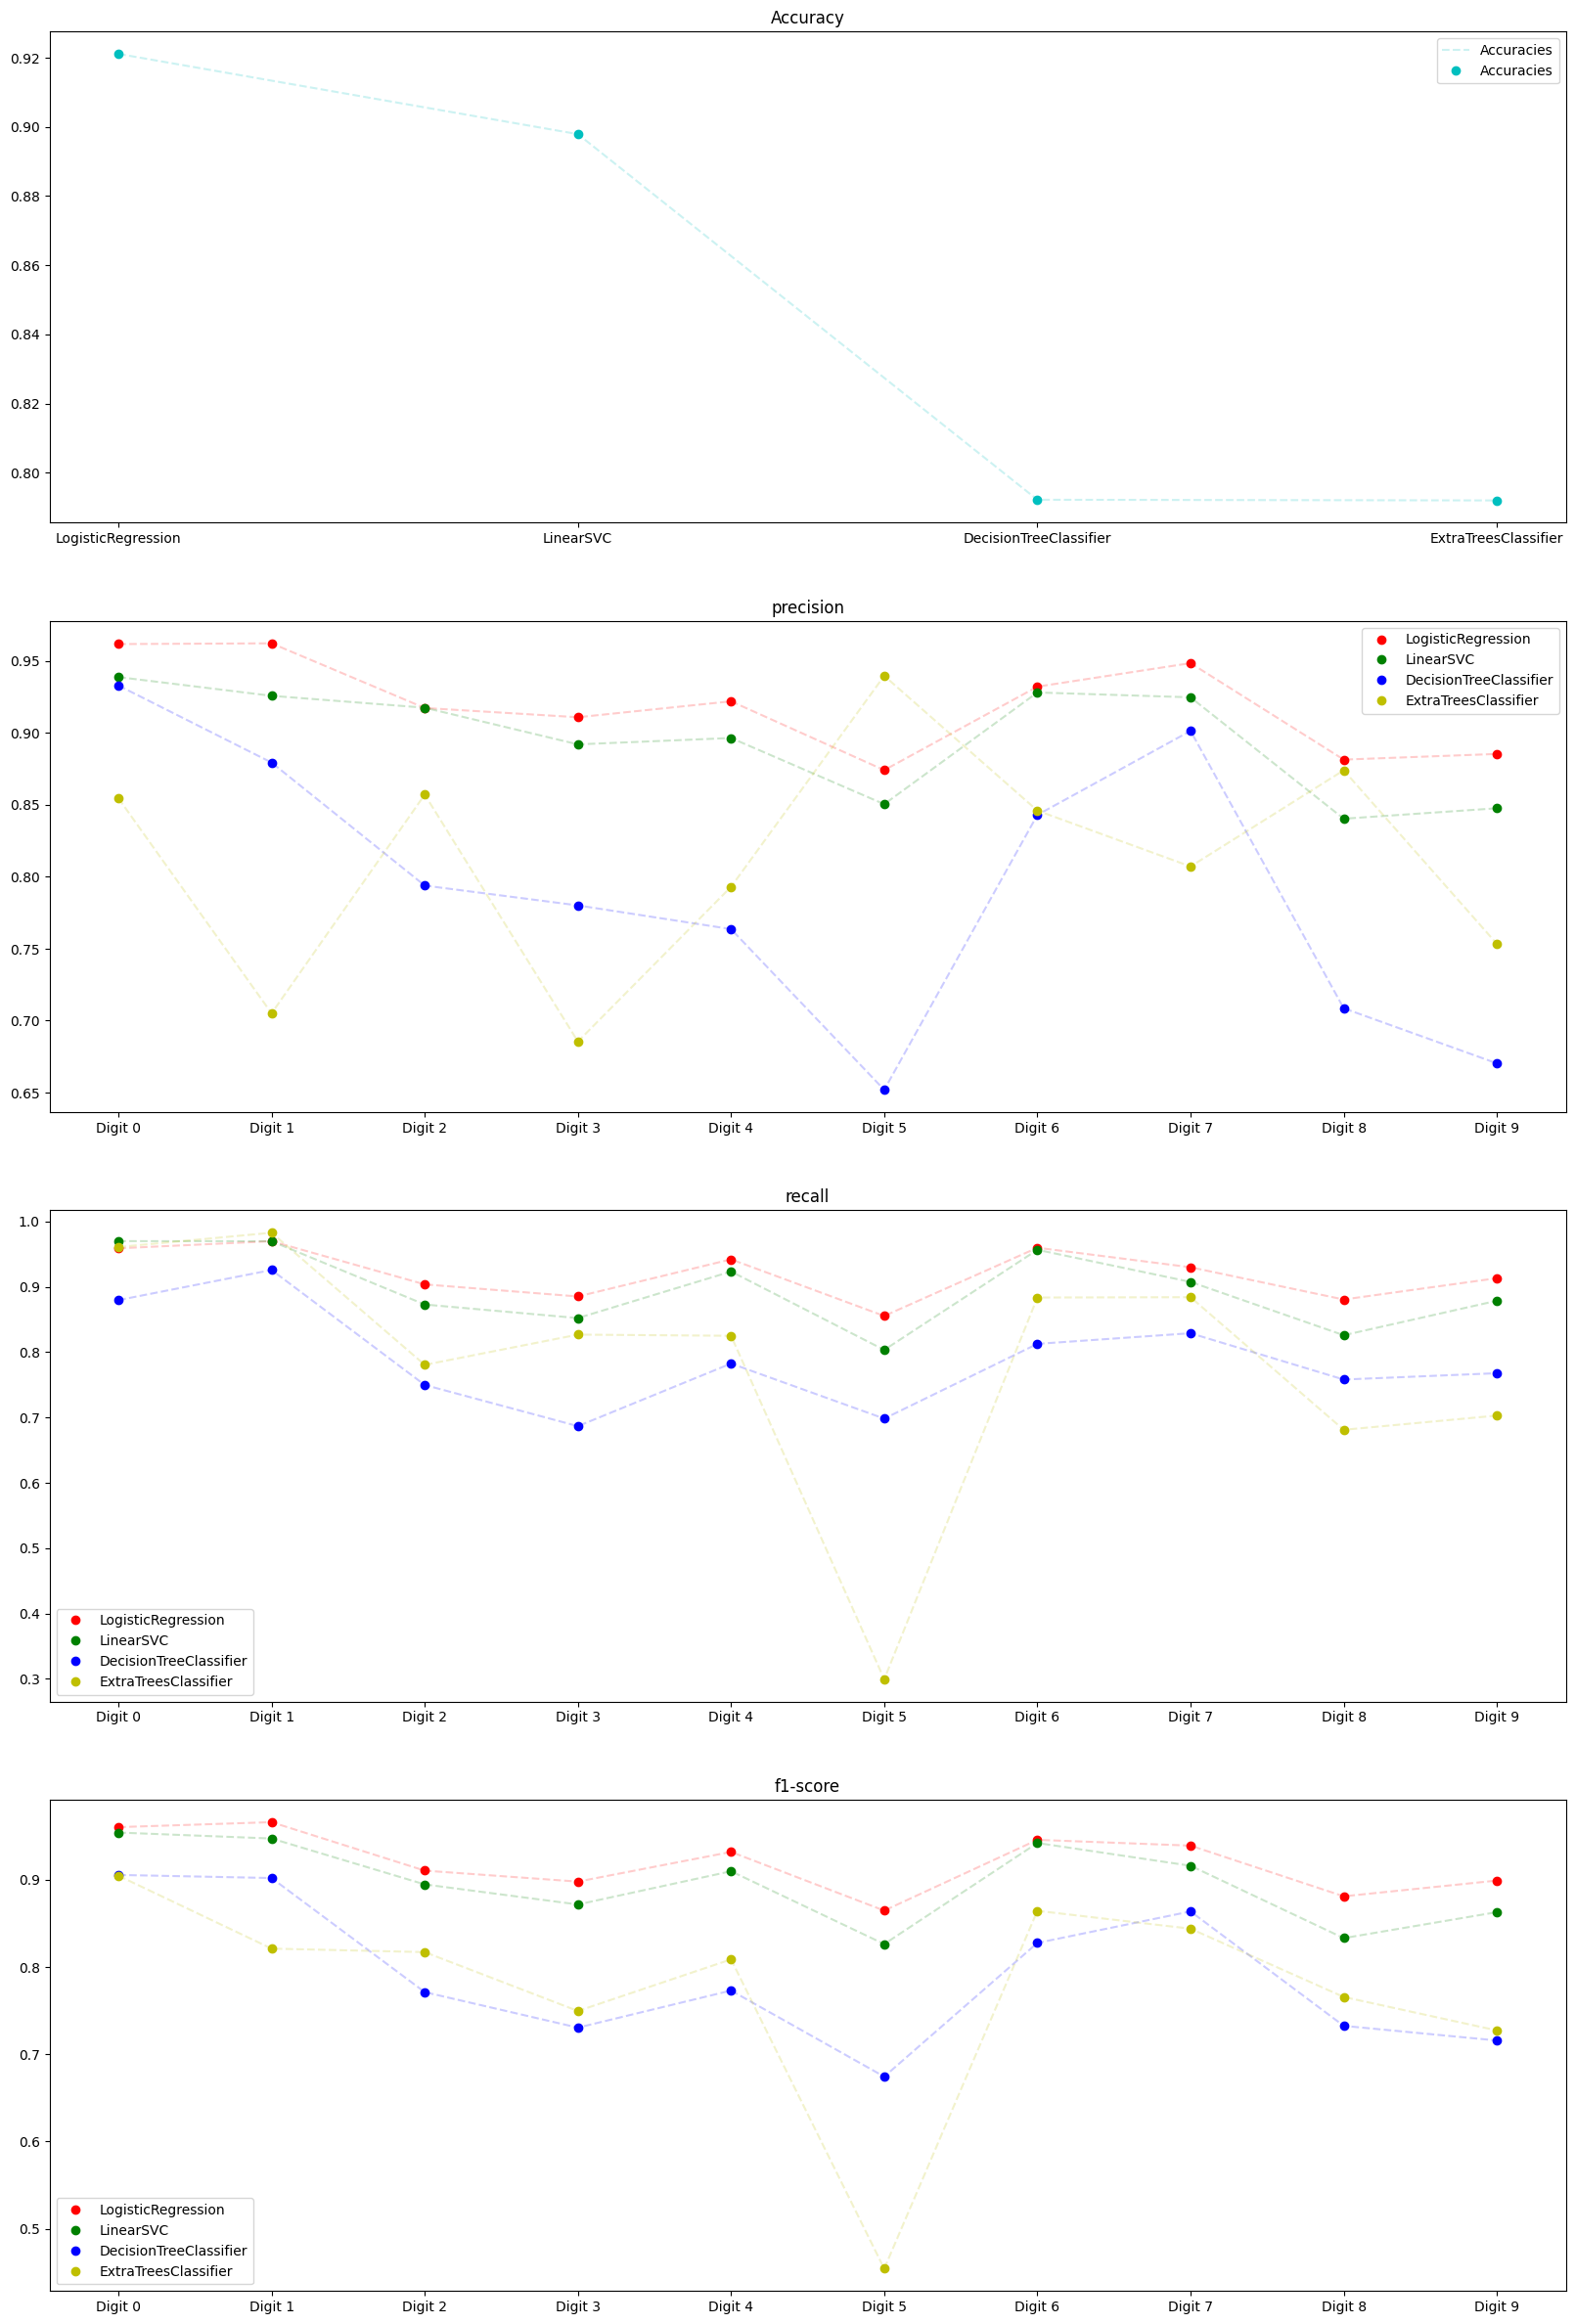

In [71]:
plot_performances(performance_base_models, seperate_for_each_metric=True, save=True, save_title='performance of base models')

Best performer: `LogisticRegression`
Worst performer: `ExtraTreesClassifier`

# Training - Voting Classifier

Training a voting classifier using these models

In [74]:
%%time
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('log_reg', log_reg), ('svm_clf', svm_clf), ('tree_clf', tree_clf), ('xtraa_trees_clf', xtraa_trees_clf)], 
                             n_jobs=-1, verbose=True)
voting_clf.fit(X_train, y_train)

CPU times: total: 859 ms
Wall time: 37.8 s


VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=0.8,
                                                 multi_class='multinomial',
                                                 penalty='l1', random_state=42,
                                                 solver='saga', tol=0.1,
                                                 verbose=3)),
                             ('svm_clf',
                              LinearSVC(C=10, dual=False, max_iter=100,
                                        random_state=42, tol=0.1, verbose=10)),
                             ('tree_clf',
                              DecisionTreeClassifier(max_depth=8,
                                                     max_features=0.5,
                                                     random_state=42,
                                                     splitter='random')),
                             ('xtraa_trees_clf',
                              ExtraTreesClassifier(bootstrap=True, max_depth=4,
                                                   max_samples=0.33, n_jobs=-1,
                                                   random_state=42,
                                                   verbose=5))],
                 n_jobs=-1, verbose=True)

## Performance of Hard Voting classifier

In [78]:
performance_voting_clf = model_performance_testing([voting_clf], X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [80]:
print_scores(performance_voting_clf)
print_scores(performance_base_models)


Model: VotingClassifier
Metric accuracy: 0.9004
Metric precision: 0.9022167067730535
Metric recall: 0.9004
Metric f1-score: 0.8995236084880859

Model: LogisticRegression
Metric accuracy: 0.9211
Metric precision: 0.9210785827323714
Metric recall: 0.9211
Metric f1-score: 0.9209944573955569

Model: LinearSVC
Metric accuracy: 0.8979
Metric precision: 0.8974967333220637
Metric recall: 0.8979
Metric f1-score: 0.897370602481866

Model: DecisionTreeClassifier
Metric accuracy: 0.7922
Metric precision: 0.796666787616875
Metric recall: 0.7922
Metric f1-score: 0.7932488714174092

Model: ExtraTreesClassifier
Metric accuracy: 0.792
Metric precision: 0.8080944391957201
Metric recall: 0.792
Metric f1-score: 0.7800718661827525


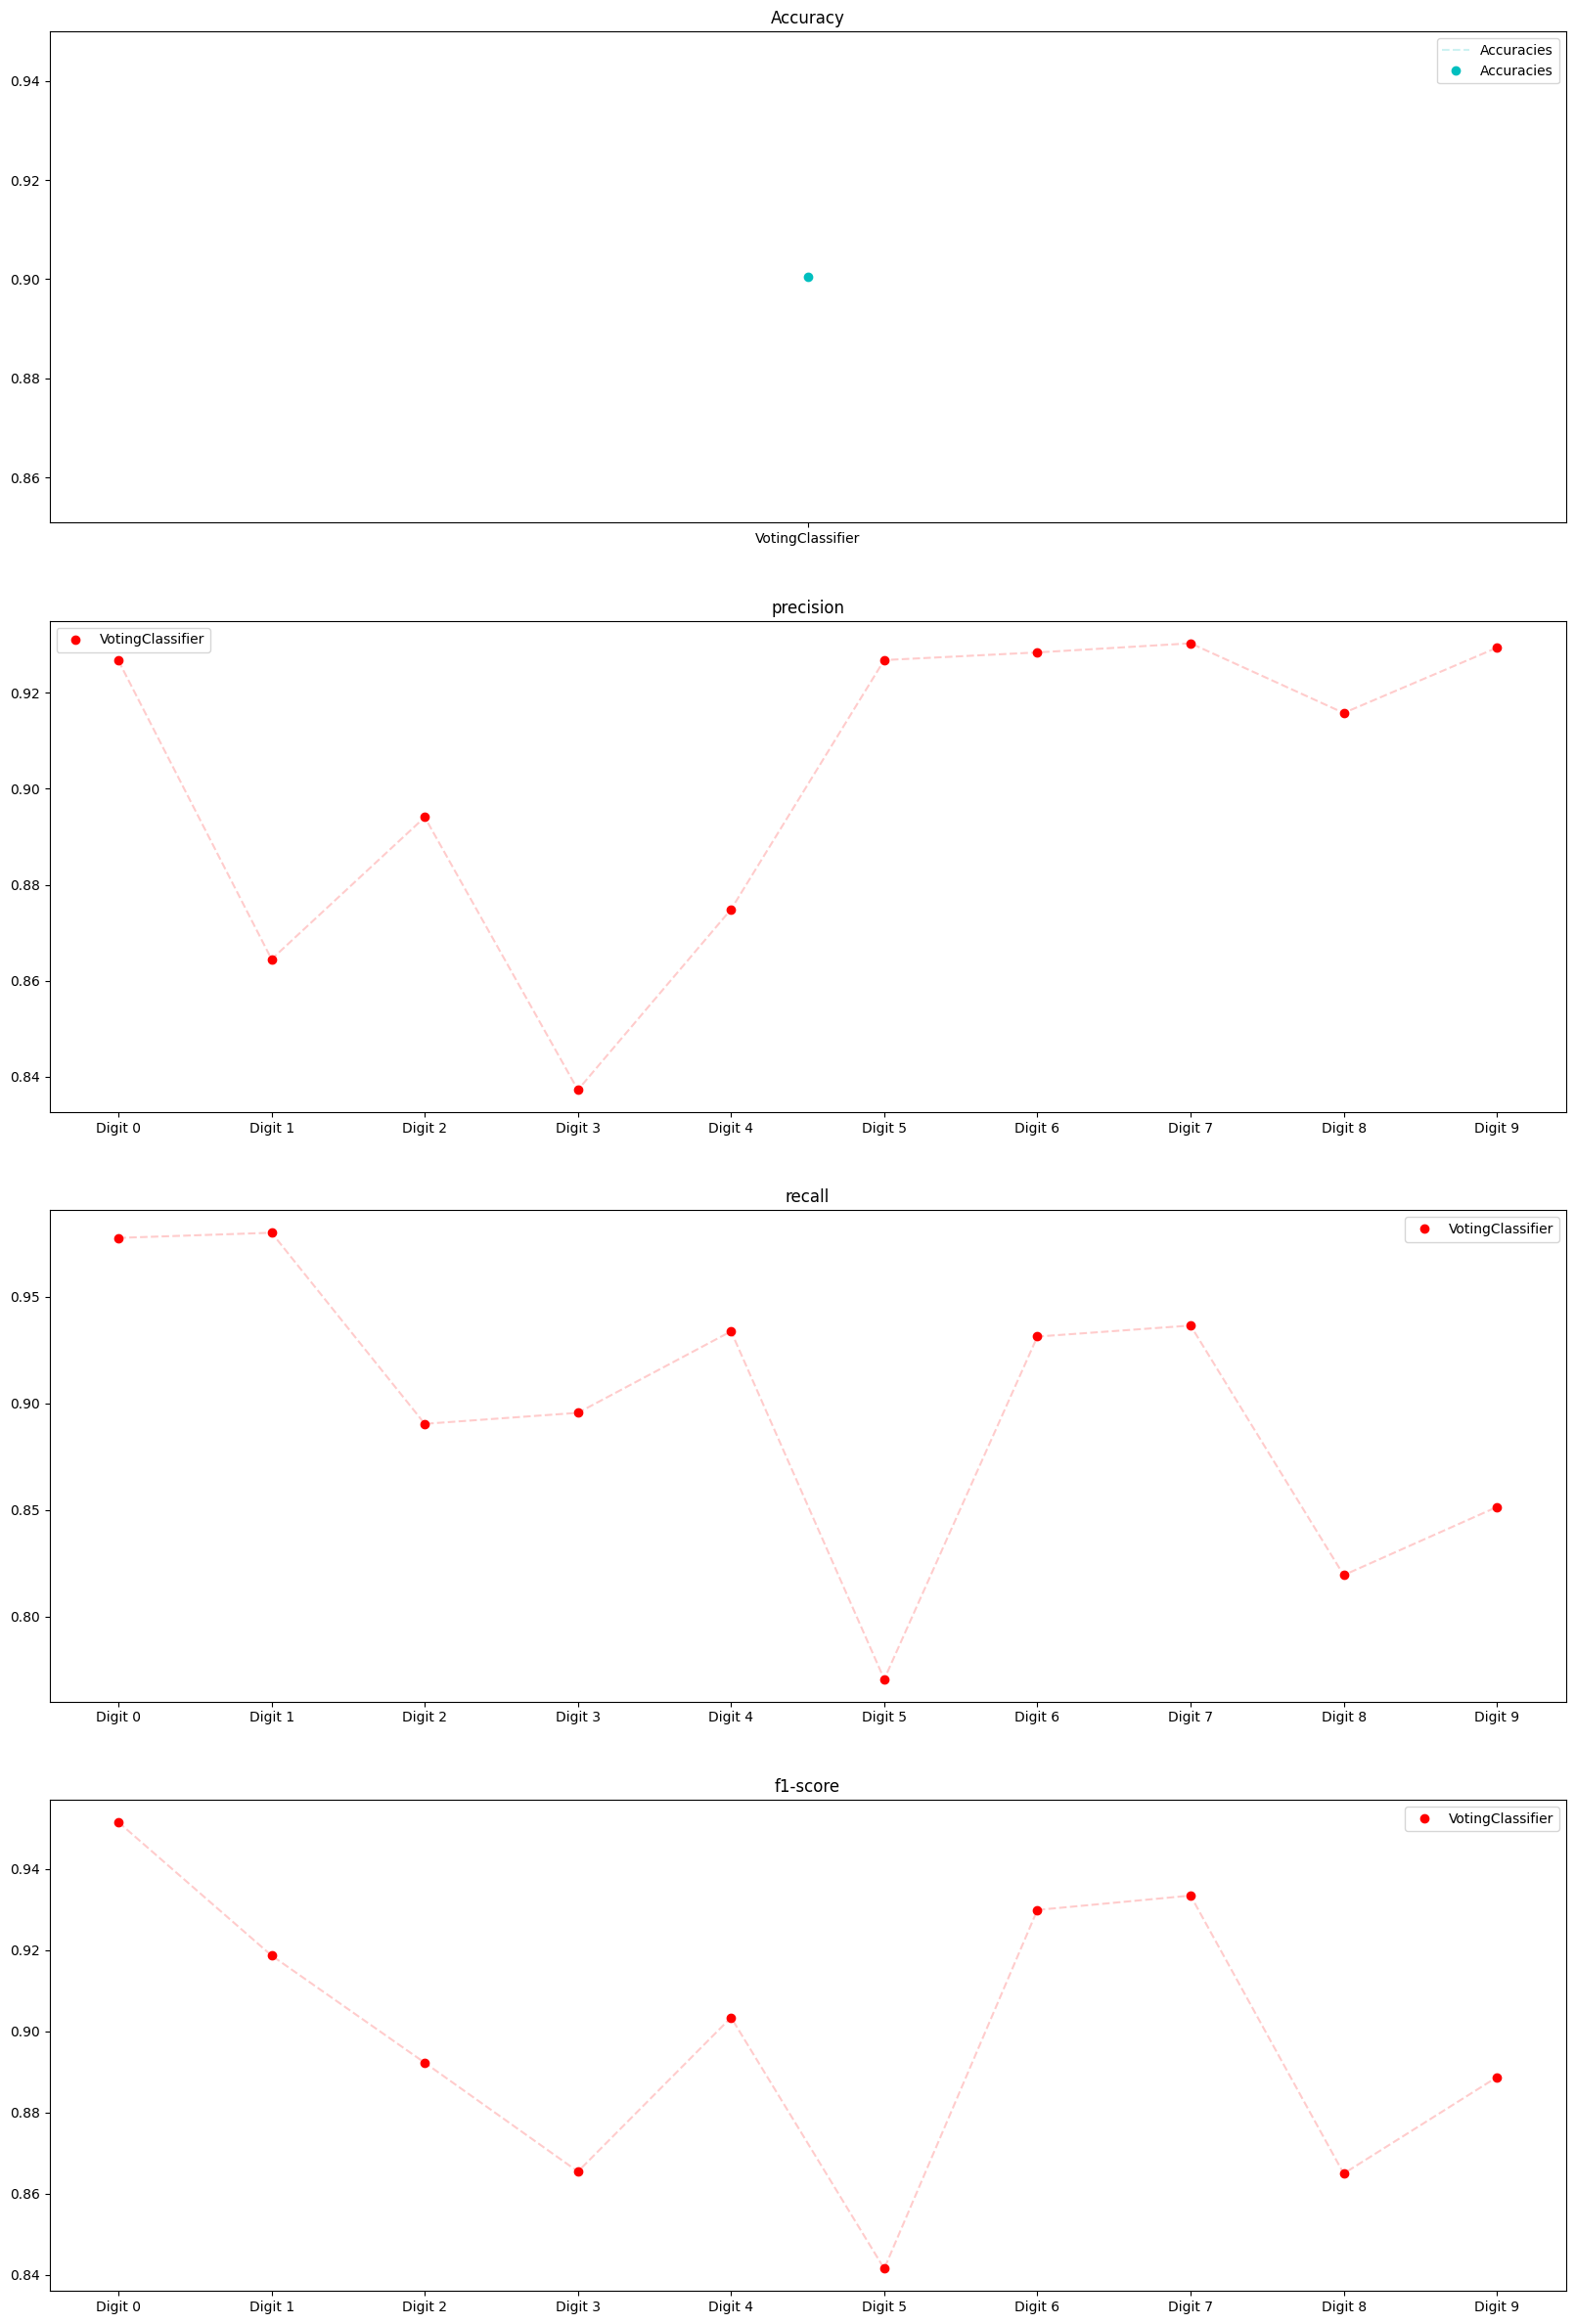

In [82]:
plot_performances(performance_voting_clf, seperate_for_each_metric=True, save=True, save_title='Performance of Hard voting clf')

Saving the model

`DecisionTreeClassifier` seems to be making voting classifier perform bad. Removing it for now and check the performance again.

In [92]:
voting_clf.set_params(tree_clf=None, xtraa_trees_clf=xtraa_trees_clf)

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=0.8,
                                                 multi_class='multinomial',
                                                 penalty='l1', random_state=42,
                                                 solver='saga', tol=0.1,
                                                 verbose=3)),
                             ('svm_clf',
                              LinearSVC(C=10, dual=False, max_iter=100,
                                        random_state=42, tol=0.1, verbose=10)),
                             ('tree_clf', None),
                             ('xtraa_trees_clf',
                              ExtraTreesClassifier(bootstrap=True, max_depth=4,
                                                   max_samples=0.33, n_jobs=-1,
                                                   random_state=42,
                                                   verbose=5))],
                 n_jobs=-1, verbose=True)

In [93]:
print_scores(model_performance_testing([voting_clf], X_test, y_test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished



Model: VotingClassifier
Metric accuracy: 0.9004
Metric precision: 0.9022167067730535
Metric recall: 0.9004
Metric f1-score: 0.8995236084880859


In [96]:
# Mean accuracy score
voting_clf.score(X_val, y_val)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.9056

In [17]:
%%time 
filename_voting_clf = 'Sets/voting_clf_model.pkl'

# with open(filename_voting_clf, 'wb') as file:
#     pickle.dump(voting_clf, file)
    
with open(filename_voting_clf, 'rb') as file:
    voting_clf = pickle.load(file)

CPU times: total: 0 ns
Wall time: 1.69 s


# Making Stacking Ensemble

## Making Training set for the blender

Run the individual classifiers from the previous exercise to make predictions on
the validation set, and create a new training set with the resulting predictions:
each training instance is a vector containing the set of predictions from all your
classifiers for an image, and the target is the image’s class.

In [21]:
X_val.shape, y_val.shape, X_val[:3], y_val[:3]

((10000, 784),
 (10000,),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '8', '2'], dtype=object))

Making predictions on `_val` set

In [22]:
%%time

pred_val_log_reg = log_reg.predict(X_val)
pred_val_svm_clf = svm_clf.predict(X_val)
pred_val_tree_clf = tree_clf.predict(X_val)
pred_val_xtraa_trees_clf = xtraa_trees_clf.predict(X_val)

CPU times: total: 609 ms
Wall time: 301 ms


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [23]:
base_predictors = [log_reg, svm_clf, tree_clf, xtraa_trees_clf]
len(base_predictors)

4

**Algo**: `i`th instance of each `pred_val_` set becomes `i`th instance of `X_train_blender`.

In [24]:
%%time
X_train_blender = np.empty((len(X_val), len(base_predictors)), dtype=np.float64)
y_train_blender = y_val

# # WHAT WRONG ?

# for i in np.arange(len(X_val)):
#     instance = np.zeros(len(base_predictors))
#     # making AN INSTANCE from predictions
#     for j, prediction in enumerate([pred_val_log_reg, pred_val_svm_clf, pred_val_tree_clf, pred_val_xtraa_trees_clf]):
#         instance[j] = prediction
#     X_train_blender[i] = instance

for axis1_val, pred in enumerate([pred_val_log_reg, pred_val_svm_clf, pred_val_tree_clf, pred_val_xtraa_trees_clf]):
    X_train_blender[:, axis1_val] = pred
    
X_train_blender.shape, y_train_blender.shape

CPU times: total: 0 ns
Wall time: 0 ns


((10000, 4), (10000,))

In [25]:
X_train_blender[:5]

array([[5., 5., 5., 9.],
       [8., 8., 8., 8.],
       [2., 2., 2., 1.],
       [4., 4., 4., 4.],
       [4., 4., 4., 4.]])

## Saving these sets

In [33]:
filename_blender_train_sets = 'Sets/BlenderTrainingSets.npz'

np.savez(filename_blender_train_sets, X=X_train_blender, y=y_val)

blender_training_data = np.load(filename_blender_train_sets, allow_pickle=True)
blender_training_data.files

['X', 'y']

In [35]:
X_train_blender = blender_training_data['X']
y_train_blender = blender_training_data['y']

X_train_blender.shape, y_train_blender.shape, X_train_blender, y_train_blender

((10000, 4),
 (10000,),
 array([[5., 5., 5., 9.],
        [8., 8., 8., 8.],
        [2., 2., 2., 1.],
        ...,
        [7., 7., 4., 7.],
        [6., 6., 6., 6.],
        [7., 7., 7., 7.]]),
 array(['5', '8', '2', ..., '7', '6', '7'], dtype=object))

## Training - Blender

Now training sets for the blender are made, using `RandomForestClassifier` as the blender

In [37]:
from sklearn.ensemble import RandomForestClassifier

blender = RandomForestClassifier(n_estimators=200, max_depth=10, max_features=None, max_samples=1/3,
                                random_state=42, verbose=10 )
%time blender.fit(X_train_blender, y_train_blender)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


RandomForestClassifier(max_depth=10, max_features=None,
                       max_samples=0.3333333333333333, n_estimators=200,
                       random_state=42, verbose=10)

In [38]:
blender.predict([[2, 1, 1, 1]])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


array(['2'], dtype=object)

## Stacking the Stacking Ensemble

Making a Pipeline for the `Stacking` ensemble: $x_i$ from test set is fed to the base estimators (1st layer) to make prediction. Each prediction from 1st layers models is fed to the blender (2nd layer) to final prediction $y_i$.

1st creating a function the combines all predictions from 1st layer into suitable format

In [ ]:
tree_clf, xtraa_trees_clf

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

class FirstLayer(BaseEstimator, TransformerMixin):
    
    def __init__(self, log_reg=True, svm_clf=True, tree_clf=True, xtraa_trees_clf=True):
        self.log_reg = log_reg
        self.svm_clf = svm_clf
        self.tree_clf = tree_clf
        self.xtraa_trees_clf = xtraa_trees_clf
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # predicting individual predictions
        if self.log_reg:
            pred_log_reg = log_reg.predict(X)
        if self.svm_clf:
            pred_svm_clf = svm_clf.predict(X)
        if self.tree_clf:
            pred_tree_clf = tree_clf.predict(X)
        if self.xtraa_trees_clf:
            pred_xtraa_trees_clf = xtraa_trees_clf.predict(X)
        
        X_for_blender = np.empty((len(X), len(base_predictors)))
        
        for axis1_val, pred in enumerate([pred_log_reg, pred_svm_clf, pred_tree_clf, pred_xtraa_trees_clf]):
            X_for_blender[:, axis1_val] = pred
        
        return X_for_blender

In [42]:
layer1 = FirstLayer()

layer1.fit_transform(X_val[:5])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[5., 5., 5., 9.],
       [8., 8., 8., 8.],
       [2., 2., 2., 1.],
       [4., 4., 4., 4.],
       [4., 4., 4., 4.]])

In [43]:
from sklearn.pipeline import Pipeline

stacking_ensemble = Pipeline([
    ('first_layer', FirstLayer()),
    ('blender', blender)
])

In [44]:
stacking_ensemble.predict(X_val[3:10]), y_val[3:10]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parall

(array(['4', '4', '2', '3', '9', '4', '4'], dtype=object),
 array(['4', '4', '2', '5', '9', '4', '4'], dtype=object))

YYYYYEEEEEEEEEEEESSSSSSSSSSSSSSSSSSSSSSS !!!!! 

## Checking performance on test set

In [46]:
test_sets = np.load(filesave_path+'.npz', allow_pickle=True)

X_test = test_sets['X']
y_test = test_sets['y']

X_test.shape, y_test.shape

((10000, 784), (10000,))

In [47]:
performance_stacking_ensemble = model_performance_testing([stacking_ensemble], X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parall

In [48]:
print_scores(performance_stacking_ensemble)


Model: Pipeline
Metric accuracy: 0.9203
Metric precision: 0.9201284509795551
Metric recall: 0.9203
Metric f1-score: 0.9200862453429937


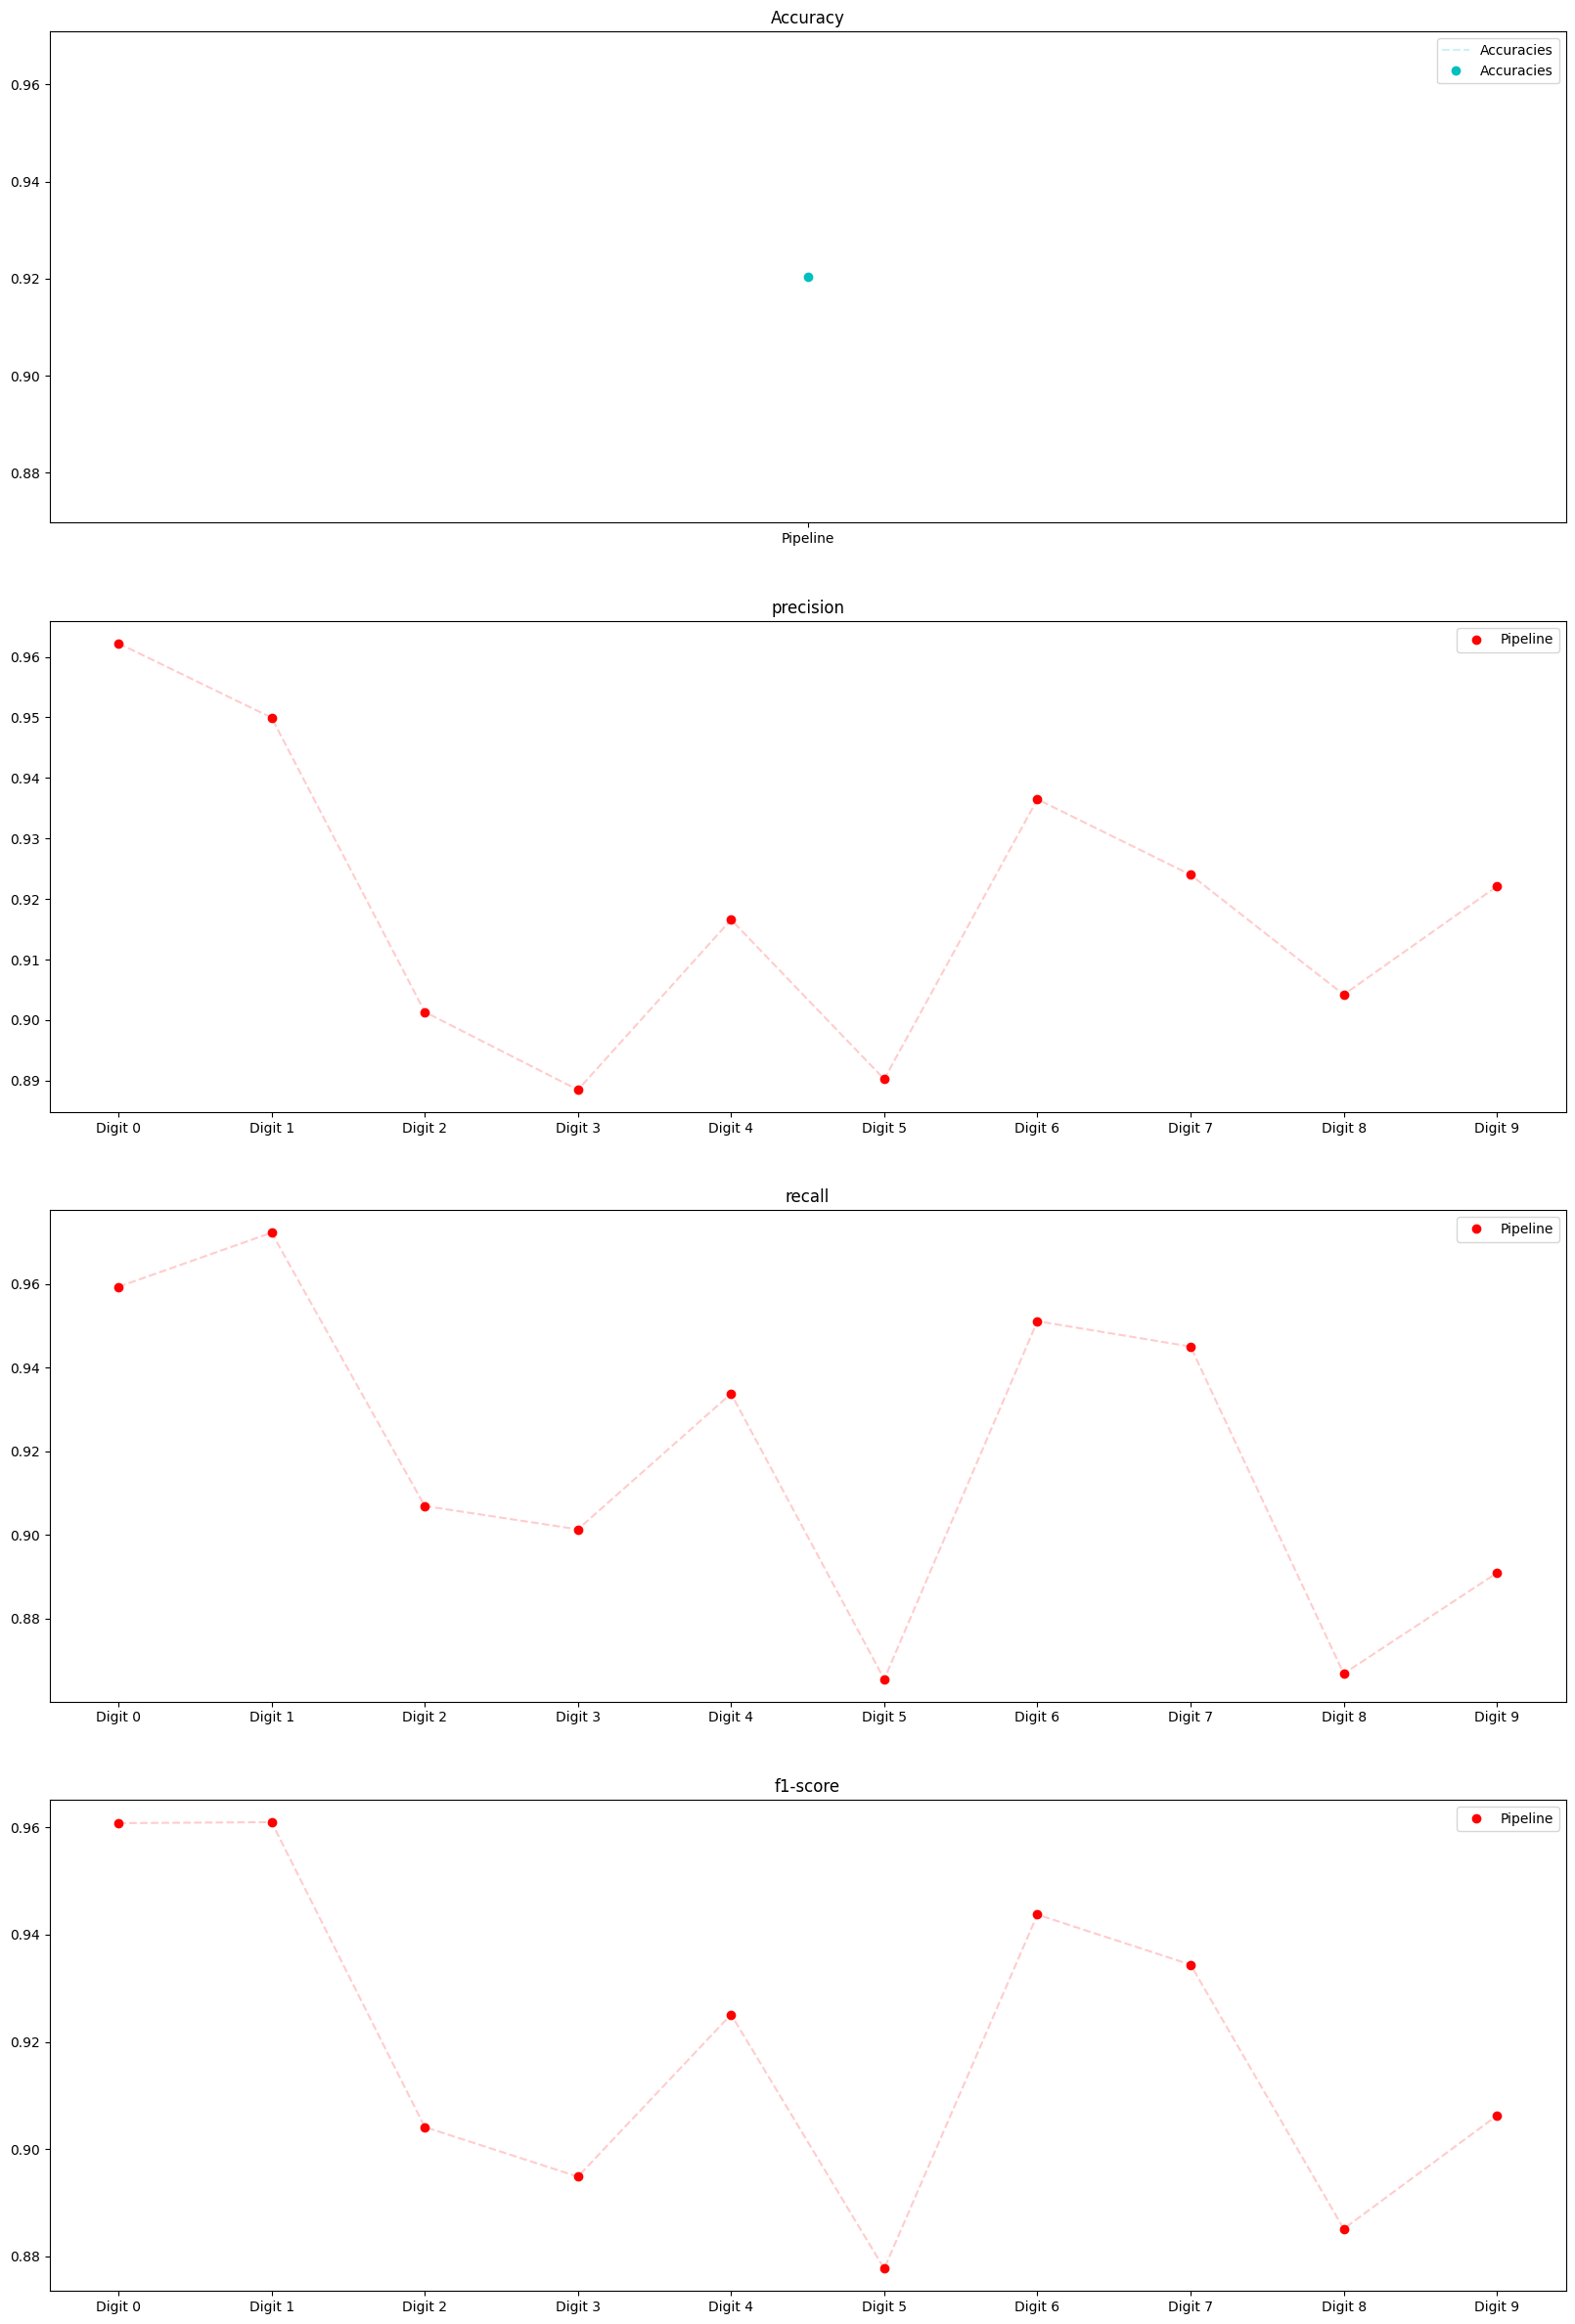

In [50]:
plot_performances(performance_stacking_ensemble, seperate_for_each_metric=True, save=True, save_title='performance stacking')

# Final comparision between all...

In [52]:
performance_all = model_performance_testing([log_reg, svm_clf, tree_clf, xtraa_trees_clf, voting_clf, stacking_ensemble], 
    X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: D

In [53]:
print_scores(performance_all)


Model: LogisticRegression
Metric accuracy: 0.9189
Metric precision: 0.9187083969807912
Metric recall: 0.9189
Metric f1-score: 0.9186984630149384

Model: LinearSVC
Metric accuracy: 0.9008
Metric precision: 0.9002628604337626
Metric recall: 0.9008
Metric f1-score: 0.900165730410674

Model: DecisionTreeClassifier
Metric accuracy: 0.7919
Metric precision: 0.7951010672213729
Metric recall: 0.7919
Metric f1-score: 0.7926662564092556

Model: ExtraTreesClassifier
Metric accuracy: 0.7886
Metric precision: 0.809466891122938
Metric recall: 0.7886
Metric f1-score: 0.7784812158693909

Model: VotingClassifier
Metric accuracy: 0.9004
Metric precision: 0.9022167067730535
Metric recall: 0.9004
Metric f1-score: 0.8995236084880859

Model: Pipeline
Metric accuracy: 0.9203
Metric precision: 0.9201284509795551
Metric recall: 0.9203
Metric f1-score: 0.9200862453429937


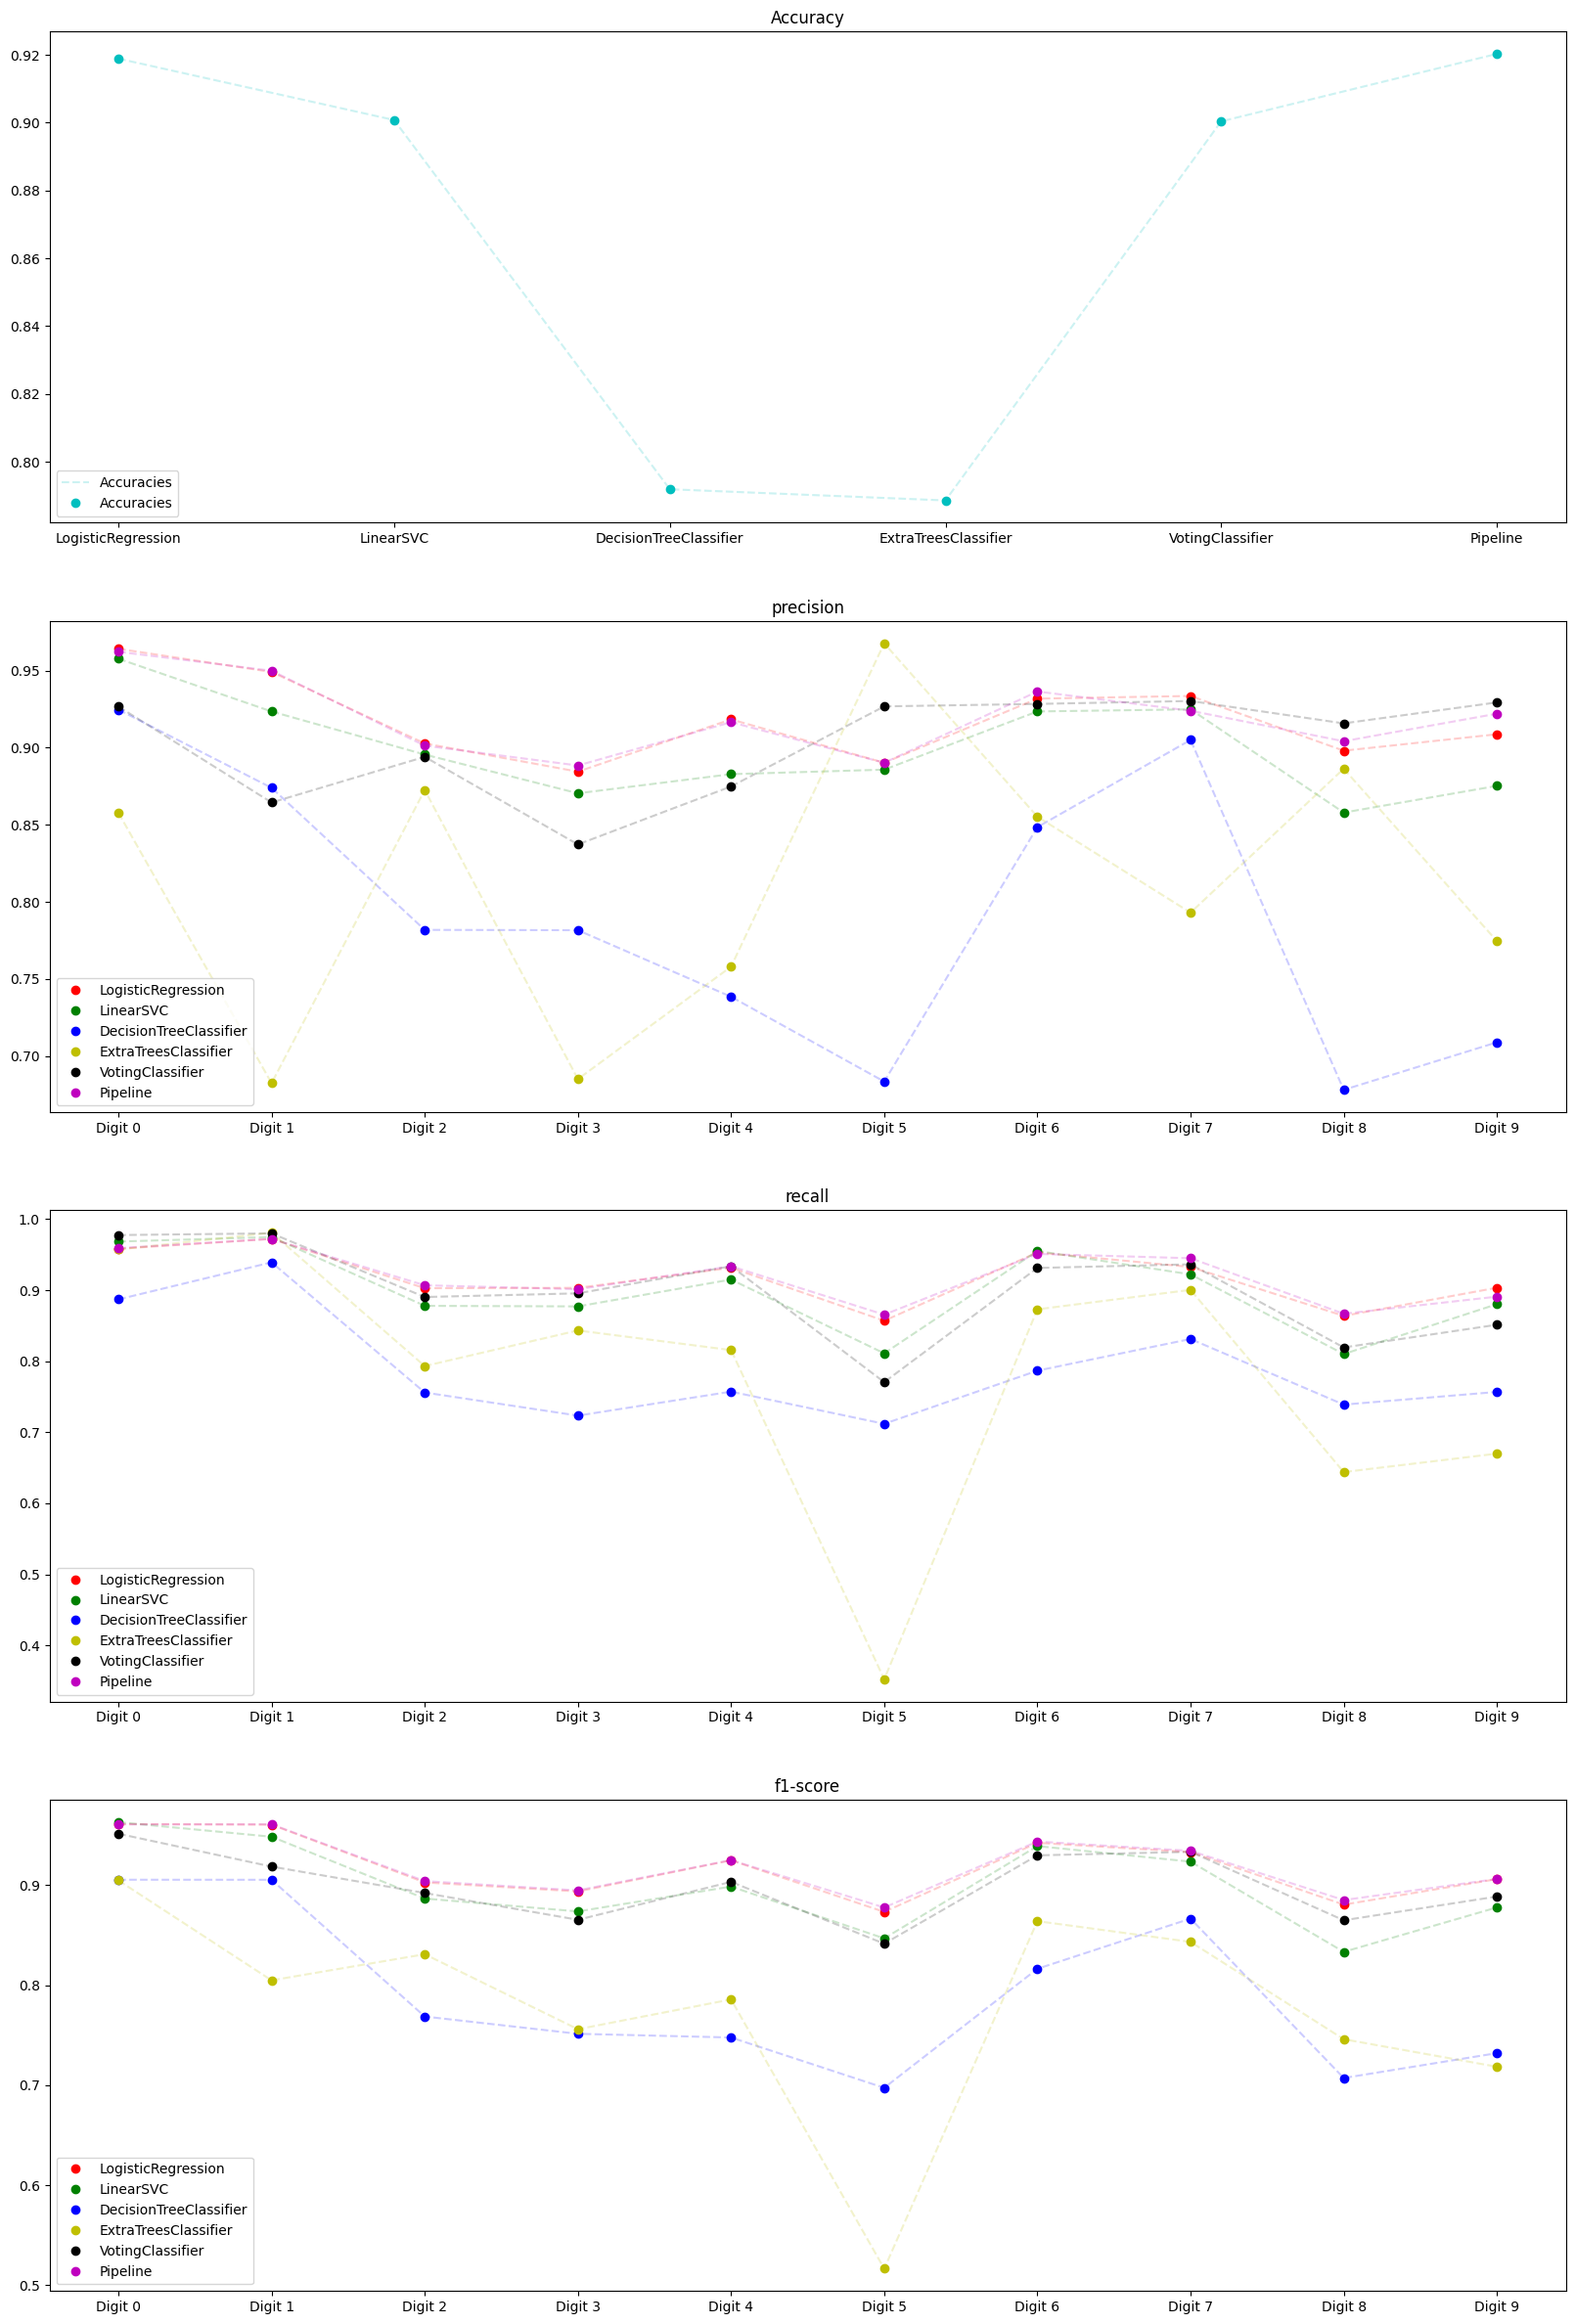

In [57]:
plot_performances(performance_all, seperate_for_each_metric=True, save=True, save_title='Final performance of all models')